In [1]:
%load_ext autoreload
%autoreload 2

import cosmohmc.polynom.sampler as sampler
import numpy as np
from matplotlib import pyplot as plt
import corner

In [10]:
def polynom_model(x, a, b,c, d):
    return a * x**3 + b*x**2 + c*x+ d

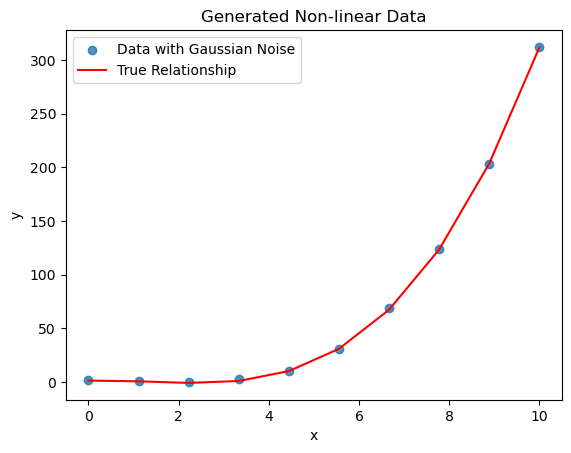

In [62]:
# True parameters
a_true = 0.5
b_true = -2.0
c_true = 1.0
d_true = 1.5
n_points = 10

# Generating synthetic data
np.random.seed(42)  # For reproducibility

# Generate data
x = np.linspace(0, 10, n_points)
y_true = polynom_model(x, a_true, b_true, c_true, d_true)
y_noisy = y_true + np.random.normal(scale=1.0, size=n_points)

# Plotting the generated data
plt.scatter(x, y_noisy, alpha=0.8, label='Data with Gaussian Noise')
plt.plot(x, y_true, color='red', label='True Relationship')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Generated Non-linear Data')
plt.show()


Estimated parameters: a = 5.49, b = -11.14, c = -5.07, d = 19.09


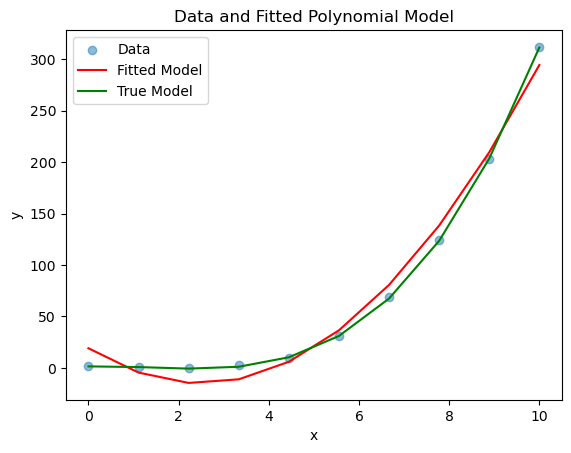

In [63]:
from scipy.optimize import minimize

def polynomial_model(x, params):
    a, b, c, d = params
    return a * x**2 + b * x*2 + c*x + d

def loss_function(params, x, y):
    y_pred = polynomial_model(x, params)
    return np.sum((y - y_pred)**2)

# Initial guess for the parameters
initial_guess = [1.0, 1.0, 1.0, 1.0]

# Minimize the loss function
result = minimize(loss_function, initial_guess, args=(x, y_noisy))

# The optimal parameters
a_est, b_est, c_est, d_est = result.x

print(f"Estimated parameters: a = {a_est:.2f}, b = {b_est:.2f}, c = {c_est:.2f}, d = {d_est:.2f}")

# Plot the fitted curve
plt.scatter(x, y_noisy, alpha=0.5, label='Data')
plt.plot(x, polynomial_model(x, result.x), color='red', label='Fitted Model')
plt.plot(x, y_true, color='green', label='True Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data and Fitted Polynomial Model')
plt.legend()
plt.show()

In [87]:
linear_dist = sampler.PolynomPost_flex(model_fn=polynom_model,x_data=x, y_data=y_noisy, grad_fn = None, proposal_width=0.5, step_size=0.00075, n_steps=100, n_samples=100000, sigma=1)

In [88]:
mc_samples, acc_mc = linear_dist.mcmc_sample()
hmc_samples, acc_hmc = linear_dist.hmc_sample()

Sampling (HMC): 100%|██████████| 100000/100000 [30:38<00:00, 54.38it/s] 


In [89]:
burnin = 10000
mc_samples = mc_samples[burnin:]
hmc_samples = hmc_samples[burnin:]

In [90]:
print("MCMC acceptance rate: ", acc_mc)
print("HMC acceptance rate: ", acc_hmc)

MCMC acceptance rate:  0.00048
HMC acceptance rate:  0.93867


In [91]:
x_line = np.linspace(np.min(x), np.max(x), 100)
true_values = [a_true, b_true, c_true, d_true]

y_original_line = a_true * x_line**3 + b_true * x_line**2 + c_true * x_line + d_true
# Assuming `hmc_samples` contains samples for parameters a, b, c of a quadratic model in order
y_line_mean_mc, y_line_upper_mc, y_line_lower_mc = linear_dist.generate_polynomial_lines(mc_samples, x_line)
y_line_mean_hmc, y_line_upper_hmc, y_line_lower_hmc = linear_dist.generate_polynomial_lines(hmc_samples, x_line)

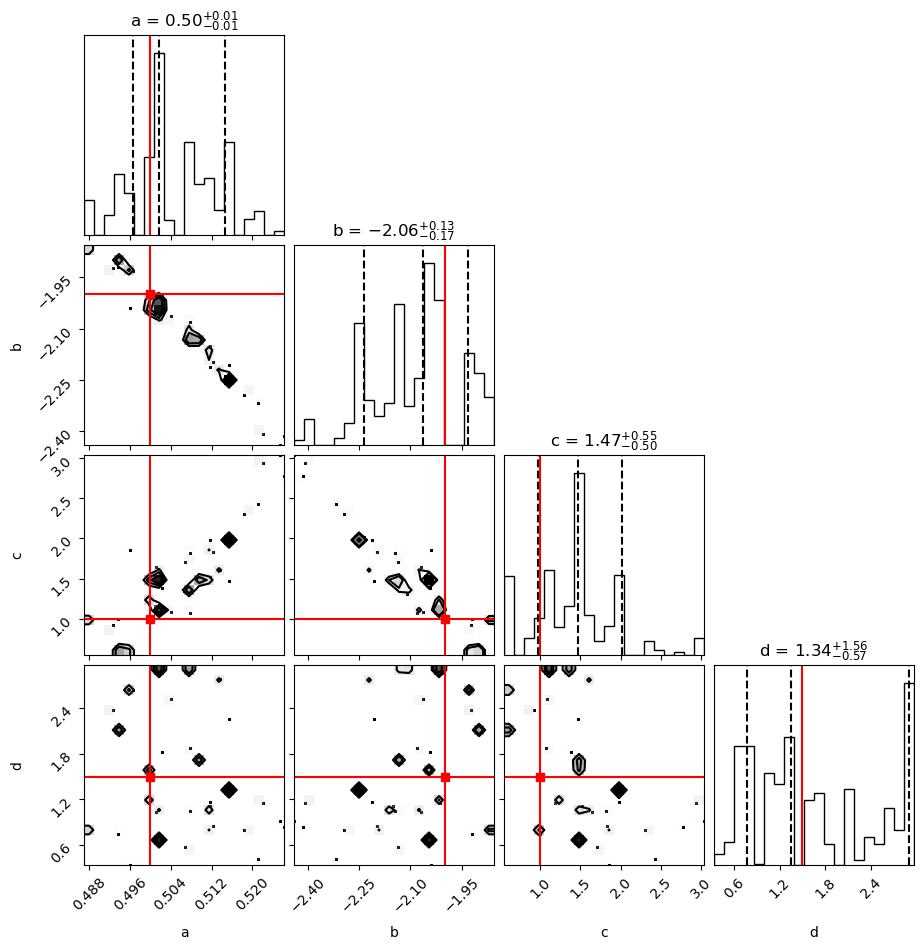

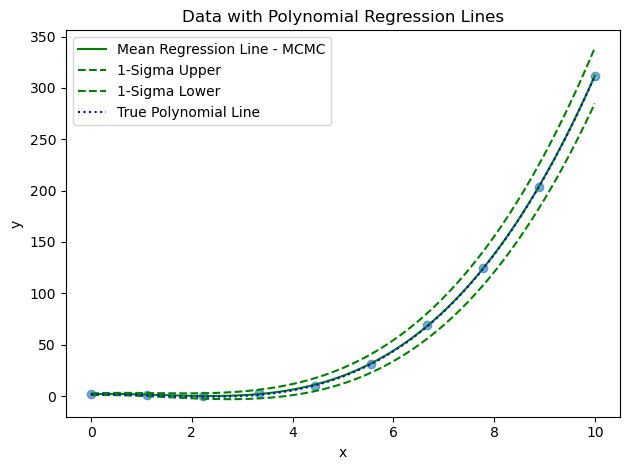

In [92]:
figure = corner.corner(mc_samples, labels=["a", "b", "c", "d"],
                       quantiles=[0.16, 0.5, 0.84], show_titles=True,
                       truths=true_values,  # Add the true values here
                       title_kwargs={"fontsize": 12}, truth_color="red")

# Optionally set a super title for the figure
#figure.suptitle('Corner Plot with True Values', fontsize=16)
plt.show()

plt.scatter(x, y_noisy, alpha=0.6)
plt.plot(x_line, y_line_mean_mc, color='green', label='Mean Regression Line - MCMC')
plt.plot(x_line, y_line_upper_mc, color='green', linestyle='dashed', label='1-Sigma Upper')
plt.plot(x_line, y_line_lower_mc, color='green', linestyle='dashed', label='1-Sigma Lower')
plt.plot(x_line, y_original_line, color='blue', linestyle='dotted', label='True Polynomial Line')
plt.title('Data with Polynomial Regression Lines')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

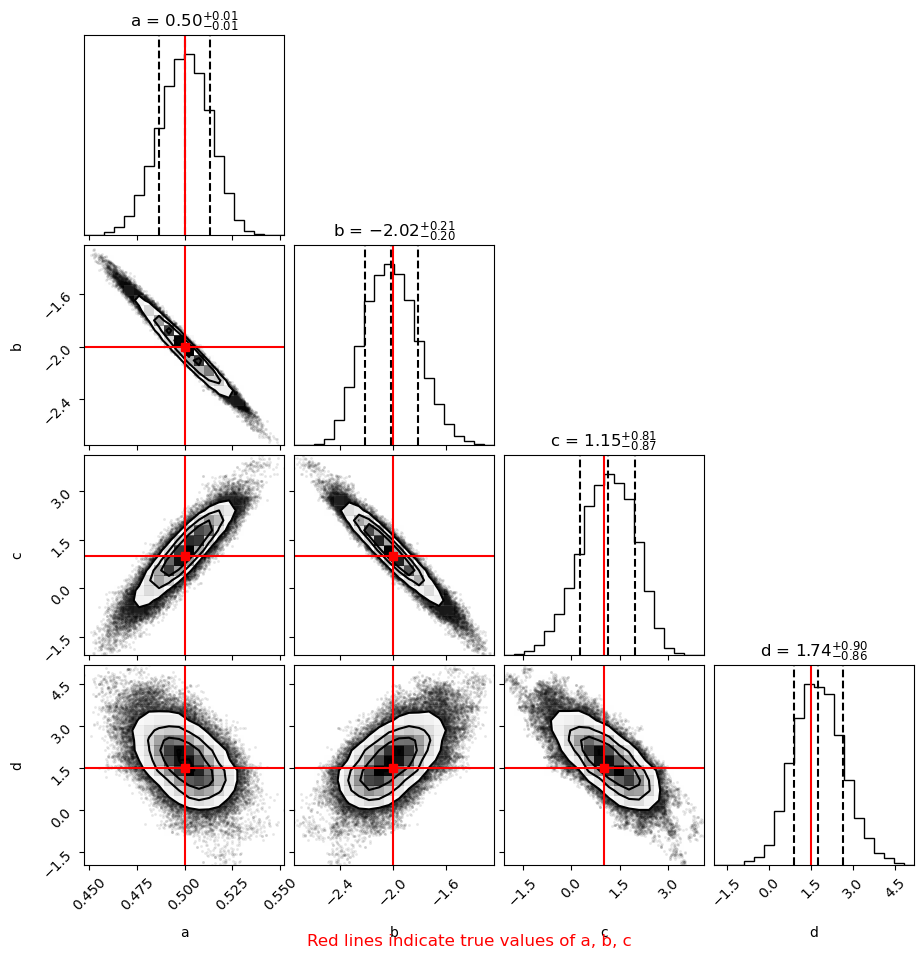

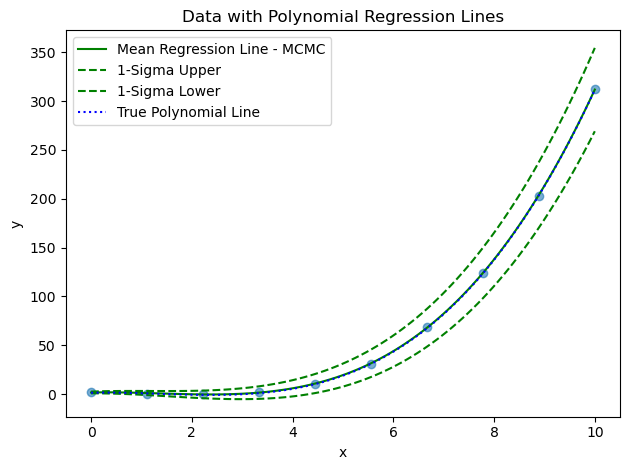

In [93]:
# Generating the corner plot without a super title
figure = corner.corner(hmc_samples, labels=["a", "b", "c", "d"],
                       quantiles=[0.16, 0.5, 0.84], show_titles=True,
                       truths=true_values, truth_color="red",
                       title_kwargs={"fontsize": 12})

# Instead of a legend, use plt.figtext to annotate the true values
plt.figtext(0.5, 0.02, "Red lines indicate true values of a, b, c", ha="center", fontsize=12, color="red")

plt.show()

plt.scatter(x, y_noisy, alpha=0.6)
plt.plot(x_line, y_line_mean_hmc, color='green', label='Mean Regression Line - MCMC')
plt.plot(x_line, y_line_upper_hmc, color='green', linestyle='dashed', label='1-Sigma Upper')
plt.plot(x_line, y_line_lower_hmc, color='green', linestyle='dashed', label='1-Sigma Lower')
plt.plot(x_line, y_original_line, color='blue', linestyle='dotted', label='True Polynomial Line')
plt.title('Data with Polynomial Regression Lines')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()